# Help Find Matching Past Solutions and Writeups

The main idea of this notebook is to try and see how to use Gemma to help a Kaggle competitor find solutions for Kaggle competitions based on past similar competitions. 

### Example Competition

I start with taking an example competition to try to find potential approaches for. In this case, I have taken the (currently) ongoing competition [Home Credit - Credit Risk Model Stability](https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability).

### Finding Similar Competitions

First step is to find competitions similar to the selected one, in this case to the [Home Credit - Credit Risk Model Stability](https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability) competition. The competition descriptions and similarity search are for this task. 

First, similarity search for the descriptions is based on the [nomic-embed-text-v1.5](https://huggingface.co/nomic-ai/nomic-embed-text-v1.5) embedding model. With 8k token window (same as Gemma) it should be able to handle long descriptions. Good ranking on the [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard) helps as well.

Second, a re-ranker model [bge-reranker-v2-gemma](https://huggingface.co/BAAI/bge-reranker-v2-gemma) is to trial a Gemma LLM based approach for the same task. The end result for this model in this task is not so great, but gives some idea on different angles to apply this type of LLM.

### Summaries for Related Competitions

Once the related competitions are selected via similarity search, a writeup dataset is used to collect solution writeups for those competitions. These writeups are summarized into a smaller set of key points using Gemma, based on learnings from my [previous notebook](https://www.kaggle.com/code/donkeys/gemma-for-kaggle-writeup-summaries) on Gemma summarization. As an additional finding, Gemma seems to handle hierarchical summarization quite well here.

### Solution Details

The key points from the writeup summaries are used as basis for question formulation about the used solutions. These questions are answered using Gemma's chat-interface. The context to answer those questions is retrieved using embeddings similarity search. This context selection is further refined by trialing two re-ranking approaches, a traditional cross-encoder model [mxbai-rerank-large-v1](#https://huggingface.co/mixedbread-ai/mxbai-rerank-large-v1), and again the Gemma-based LLM re-ranker [bge-reranker-v2-gemma](https://huggingface.co/BAAI/bge-reranker-v2-gemma).

## Summary of Learnings

- **Summarization**: In my [previous notebook](https://www.kaggle.com/code/donkeys/gemma-for-kaggle-writeup-summaries) I experimented with Gemma summarization. Gemma was picky on the prompting, and tended to about 200-300 token summary length regardless of input size. Similar results seem to apply here.
- **Hierarchical summarization**: Summarizing smaller subsets of writeups first, then these to a final summary helps manage GPU memory use. Gemma did quite well on this.
- **Re-Ranking**: The Gemma based [bge-reranker-v2-gemma](https://huggingface.co/BAAI/bge-reranker-v2-gemma) re-ranker did poorly on description search, but better on direct question answering task. Perhaps because the description search is not a direct question-based search for which the model seems tuned.
- **Question Answering (RAG)**: [Gemma 7B-it](https://huggingface.co/google/gemma-7b-it) stuck to the given context even a bit stubbornly. Asking it to think more generally beyond the given context just resulted in stating the requested information is not in the given context. Re-building the context and tuning the query fixed it.

### Version history:
- v1: Summarization, re-ranker comparison, RAG experiments
- v2: Clarified descriptions, made datasets (uploaded models) public, commented out my Gemma LLM re-ranker experiments for competition descriptions as they took a long time to run but the results were not great. So no point in repeating them all the time. Just left the results as images (screenshots), and original executions are in the first public run of this notebook. Saves about 6h GPU time per execution here.


In [ ]:
#have to update these first, or otherwise it seems the libraries might not update and load older versions
!pip install -q -U transformers accelerate bitsandbytes lxml faiss-cpu einops sentence_transformers langchain

In [ ]:
!nvidia-smi

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import HTML, Markdown, display

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sentence_transformers import util
from sentence_transformers import SentenceTransformer
from sentence_transformers import CrossEncoder
import transformers
import torch.nn.functional as F
import torch
from lxml import html
import faiss
from tqdm.notebook import tqdm

from transformers import AutoTokenizer
from langchain.text_splitter import RecursiveCharacterTextSplitter

import os

on_kaggle = False
if os.path.exists("/kaggle/input"):
    on_kaggle = True

if on_kaggle:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))


In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {DEVICE}")
print(f"CUDA Version: {torch.version.cuda}")
print(f"Pytorch {torch.__version__}")

# Load Datasets

I use data from a set of Kaggle competition writeups, and competition descriptions.

In this notebook, use Gemma with RAG to find information from the writeups. The descriptions are there to give some context for the summarization of writeups, and to perform search for relevant competitions.

In [ ]:
if on_kaggle:
    df_writeups = pd.read_csv(f"/kaggle/input/2023-kaggle-ai-report/kaggle_writeups_20230510.csv")
    df_comp_meta = pd.read_csv(f"/kaggle/input/kaggles-all-completed-competition-dataset/kaggle comp_submission.csv")
else:
    df_writeups = pd.read_csv(f"/mystuff/data/kaggle_writeups_20230510.csv")
    df_comp_meta = pd.read_csv(f"/mystuff/data/kaggle_comp_submission.csv")



# Data Cleanup

Some of the writeups have a lot of HTML in them, causing the Gemma model sometimes to overflow its context window, and causing issues with the "garbage" in the text. This shows in the Writeup column here:


In [ ]:
df_writeups["Writeup"].values[0]

This `strip_html()` will remove HTML formatting from a writeup and only leave the actual text:

In [ ]:
def strip_html(html_text):
    tree = html.fromstring(html_text)
    clean_text = tree.text_content()
    return clean_text


There are 2 writeups with NAN values, dropping them cleans it up.

In [ ]:
print(f"                 Initial set of writeups: {df_writeups.shape}")
df_writeups = df_writeups.dropna(subset=['Writeup'])
print(f"After removing rows with nan for writeup: {df_writeups.shape}")
# this shows there were 2 rows with nan writeup, 3127->3125

Strip the HTML from the writeups, store in new column writeup_clean:

In [ ]:
df_writeups["writeup_clean"] = df_writeups["Writeup"].apply(strip_html)
df_writeups = df_writeups.rename(columns={'Writeup': 'writeup'})


# Metadata Checkup

The _df_comp_meta_ dataset contains competition metadata such as competition name and description.

In [ ]:
df_comp_meta.head(2)

# Preprocess Competition Metadata for Embedding model

The embedding model used (nomic-embed-text-v1.5) here is trained with "search_document:" prefix for search texts. Add it then.

In [ ]:
df_comp_meta["search_doc"] = df_comp_meta["desc"].apply(lambda x: "search_document: "+x)
df_comp_meta.head()

# Find Closest Competition

Perform similarity search over competition descriptions to find similar competitions to the one we are interested in.

In [ ]:
matryoshka_dim = 768

if on_kaggle:
    embed_model = SentenceTransformer("/kaggle/input/nomic-embed-text-v1-5-model/nomic-embed-text-v1.5", trust_remote_code=True)
else:
    embed_model = SentenceTransformer("/mystuff/llm/nomic-embed-text-v1.5", trust_remote_code=True)


In [ ]:
df_comp_meta.head()

### Embed the Docs and Query

Have to encode in smaller batches as the Kaggle GPU once again ran out of memory otherwise

In [ ]:
def encode_in_batches(my_model, documents, batch_size=16):
    embeddings = []
    for i in tqdm(range(0, len(documents), batch_size)):
        batch = list(documents[i:i+batch_size].values)
        batch_embeddings = my_model.encode(batch, convert_to_tensor=True)
        embeddings.extend(batch_embeddings)  
        
        torch.cuda.empty_cache()

    return embeddings



In [ ]:
embeddings = encode_in_batches(embed_model, df_comp_meta["search_doc"])

## Define Search Target / Query for Related Competitions

This is a description I picked from a current Kaggle competition that will be used as a search query string. The embedding model also expects the search query to be prefixed with "search_query:". So lets do that.

In [ ]:
search_comp_desc = """The absence of a credit history might mean a lot of things, including young age or a preference for cash. Without traditional data, someone with little to no credit history is likely to be denied. Consumer finance providers must accurately determine which clients can repay a loan and which cannot and data is key. If data science could help better predict one’s repayment capabilities, loans might become more accessible to those who may benefit from them the most.
Currently, consumer finance providers use various statistical and machine learning methods to predict loan risk. These models are generally called scorecards. In the real world, clients' behaviors change constantly, so every scorecard must be updated regularly, which takes time. The scorecard's stability in the future is critical, as a sudden drop in performance means that loans will be issued to worse clients on average. The core of the issue is that loan providers aren't able to spot potential problems any sooner than the first due dates of those loans are observable. Given the time it takes to redevelop, validate, and implement the scorecard, stability is highly desirable. There is a trade-off between the stability of the model and its performance, and a balance must be reached before deployment.
Founded in 1997, competition host Home Credit is an international consumer finance provider focusing on responsible lending primarily to people with little or no credit history. Home Credit broadens financial inclusion for the unbanked population by creating a positive and safe borrowing experience. We previously ran a competition with Kaggle that you can see here.
Your work in helping to assess potential clients' default risks will enable consumer finance providers to accept more loan applications. This may improve the lives of people who have historically been denied due to lack of credit history.
"""

In [ ]:
target_comp_desc = f"search_query: {search_comp_desc}"
search_q = target_comp_desc


In [ ]:
#doc_embeddings = model.encode(df_comp_meta["embeddings"], convert_to_tensor=True)
#doc_embeddings = embeddings
doc_embeddings = torch.stack(embeddings, dim=0)
doc_embeddings = F.layer_norm(doc_embeddings, normalized_shape=(doc_embeddings.shape[1],))
doc_embeddings = doc_embeddings[:, :matryoshka_dim]
doc_embeddings = F.normalize(doc_embeddings, p=2, dim=1)
#print(doc_embeddings)
q_embeddings = embed_model.encode([search_q], convert_to_tensor=True)
q_embeddings = F.layer_norm(q_embeddings, normalized_shape=(doc_embeddings.shape[1],))
q_embeddings = q_embeddings[:, :matryoshka_dim]
q_embeddings = F.normalize(q_embeddings, p=2, dim=1)

In [ ]:
q_embeddings.shape

# Find Similarities

With the embeddings, we can now perform the similarity search. And re-rank after on top of that for added accuracy.

### Brief look at the docs we are searching over:


In [ ]:
df_comp_meta["search_doc"][:10]

In [ ]:
#df_comp_meta["search_doc"][:3].values

## Similarity with Embeddings Only

Now for the actual similarity search with the embeddings only:

In [ ]:
similarities = util.cos_sim(q_embeddings[0], doc_embeddings)
#[0] = the similarities for the first (and only) search query. [:10] just to cut for show the first 10 similarity values.
similarities[0][:10]


### Get top_n count of search document with highest similarity.
- top_k_values will be to similarity scores for the top k documents.
- top_k_indices their index in the dataframe rows.

In [ ]:
top_n = 527 # the dataset has 527 competition descriptions, i try with all of them here to get a broader overview
#top_n = 20 #if we want to try re-ranking with a subset
top_k_values, top_k_indices = torch.topk(similarities, top_n)


In [ ]:
top_names_embedding = []
top_k_descs = []
# the top_k_indices is just a single list inside a list
top_k_indices = top_k_indices[0]
for idx in top_k_indices:
    comp_name = df_comp_meta.iloc[int(idx)]["comp_name"]
    top_names_embedding.append(comp_name)
    comp_desc = df_comp_meta.iloc[int(idx)]["desc"]
    top_k_descs.append(comp_desc)


In [ ]:
del embed_model

In [ ]:
import gc
gc.collect()

In [ ]:
# a better look at some of the top docs
top_k_descs[:3]

## Rerank with Gemma 2B based re-ranker

NOTE: I HAVE DISABLED RUNNING THIS PART SINCE IT EATS UP ALL THE GPU TIME AND THE RESULTS WERE NOT THAT EXCITING. HOWEVER, I KEPT THE RESULTS HERE IN FORM OF SCREENSHOTS. THE ACTUAL EXECUTIONS ARE AVAILABLE IN THE FIRST PUBLIC RUN OF THIS NOTEBOOK.

As shown above there are 527 competitions in this dataset. The normal approach would be to search those 527 competitions with the embeddings search above, and follow that with a re-ranking of the top selection of that full set. However, I am also interested in seeing how well the Gemma 2B based re-ranker does in general, so I will just run it on the full 527 competitions here. It's not a huge dataset, even if it takes longer than one would like in most real applications. But I believe this way it illlustrates better the model performance.

### Default prompt given in the re-ranker model example code:

A set of helpers first to help re-rank with Gemma 2B later, along with the default model prompt defined in it:

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# the code in get_rerank_inputs in practically from the model page at
# https://huggingface.co/BAAI/bge-reranker-v2-gemma
def get_rerank_inputs(pairs, tokenizer, prompt=None, max_length=1024):
    if prompt is None:
        #this is the default prompt given at the model page
        prompt = "Given a query A and a passage B, determine whether the passage contains an answer to the query by providing a prediction of either 'Yes' or 'No'."
    sep = "\n"
    prompt_inputs = tokenizer(prompt,
                              return_tensors=None,
                              add_special_tokens=False)['input_ids']
    sep_inputs = tokenizer(sep,
                           return_tensors=None,
                           add_special_tokens=False)['input_ids']
    inputs = []
    for query, passage in pairs:
        query_inputs = tokenizer(f'A: {query}',
                                 return_tensors=None,
                                 add_special_tokens=False,
                                 max_length=max_length * 3 // 4,
                                 truncation=True)
        passage_inputs = tokenizer(f'B: {passage}',
                                   return_tensors=None,
                                   add_special_tokens=False,
                                   max_length=max_length,
                                   truncation=True)
        item = tokenizer.prepare_for_model(
            [tokenizer.bos_token_id] + query_inputs['input_ids'],
            sep_inputs + passage_inputs['input_ids'],
            truncation='only_second',
            max_length=max_length,
            padding=False,
            return_attention_mask=False,
            return_token_type_ids=False,
            add_special_tokens=False
        )
        item['input_ids'] = item['input_ids'] + sep_inputs + prompt_inputs
        item['attention_mask'] = [1] * len(item['input_ids'])
        inputs.append(item)
    return tokenizer.pad(
            inputs,
            padding=True,
            max_length=max_length + len(sep_inputs) + len(prompt_inputs),
            pad_to_multiple_of=8,
            return_tensors='pt',
    )

def gemma_rerank(pairs, rerank_prompt):
    if on_kaggle:
        bge_gemma_tokenizer = AutoTokenizer.from_pretrained('/kaggle/input/bge-reranker-v2-gemma-model/bge-reranker-v2-gemma')
        bge_gemma_model = AutoModelForCausalLM.from_pretrained('/kaggle/input/bge-reranker-v2-gemma-model/bge-reranker-v2-gemma')
    else:
        bge_gemma_tokenizer = AutoTokenizer.from_pretrained('/mystuff/llm/bge-reranker-v2-gemma')
        bge_gemma_model = AutoModelForCausalLM.from_pretrained('/mystuff/llm/bge-reranker-v2-gemma')
    # this appears to get the "yes" token id to later check its probability
    yes_loc = bge_gemma_tokenizer('Yes', add_special_tokens=False)['input_ids'][0]
    bge_gemma_model.eval()

    all_scores = []
    for pair in tqdm(pairs):
        with torch.no_grad():
            inputs = get_rerank_inputs([pair], bge_gemma_tokenizer, rerank_prompt)
            # and this uses the "yes" token location in the logits to get the score. or so i would think :)
            scores = bge_gemma_model(**inputs, return_dict=True).logits[:, -1, yes_loc].view(-1, ).float()
            all_scores.append(float(scores))
    indices = range(len(pairs))
    del bge_gemma_model
    del bge_gemma_tokenizer
    #sort scores and pairs so the highest score is first
    all_scores, pairs, indices = zip(*sorted(zip(all_scores, pairs, indices), reverse=True))
    return all_scores, pairs, indices

# if prompt is given as parameter, it is used as custom prompt. otherwise the default one is used
def gemma_rerank_question_docs(question, docs, rerank_prompt=None):
    pairs = [[question, doc] for doc in docs]
    scores, pairs, indices = gemma_rerank(pairs, rerank_prompt)
    sorted_docs = [pair[1] for pair in pairs]
    return scores, sorted_docs, indices
    

In [ ]:
%%time
#prompt = None
#scores_gemma_default, sorted_docs_gemma_default, indices_gemma_default = gemma_rerank_question_docs(search_comp_desc, top_k_descs, prompt)



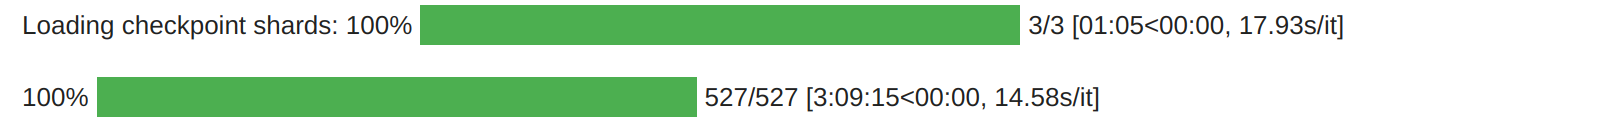

In [ ]:
#len(indices_gemma_default)

In [ ]:
# disabled since i disabled the gemma re-ranker for competition descriptions due to GPU time
if False:
    top_names_gemma_default = []
    top_k_descs_gemma_default = []

    for array_idx, gemma_idx in enumerate(indices_gemma_default[:20]):
        # top_k_descs was used as the docs above, so need to re-calculate the index to get the correct description
        idx = top_k_indices[gemma_idx]
        comp_name = df_comp_meta.iloc[int(idx)]["comp_name"]
        top_names_gemma_default.append(comp_name)
        comp_desc = df_comp_meta.iloc[int(idx)]["desc"]
        # check that the index was recalculated correctly
        if comp_desc != sorted_docs_gemma_default[array_idx]:
            print(f"mismatch at {array_idx}")
        top_k_descs_gemma_default.append(comp_desc)

In [ ]:
#len(top_names_gemma_default)

### Gemma 2B based re-ranker with a custom prompt

For comparison with the above default prompt, I trialed running the Gemma 2B based re-ranker with a custom prompt. The model page example uses a prompt that asks Gemma to rate two passages where on is a question and the other is a potential answer to that question. This was an attempt to change the prompt to instead compare descriptions.

I commented this out in the end as it takes a relatively long time to run this across the 500+ competition descriptions and the difference to the default prompt results is not big. But the prompt I tried is here:

In [ ]:
%%time
#prompt = "Given a passage A and a passage B, determine whether the passage B describes a problem that could be addressed using datascience solutions similar to those applicable the problem described in passage A. Provide a prediction of either 'Yes' or 'No'."
#scores_gemma_prompt, sorted_docs_gemma_prompt, indices_gemma_prompt = gemma_rerank_question_docs(search_comp_desc, top_k_descs, prompt)

## Compare the Top Selected Competitions / Similarity Approaches

A look at embeddings similarity vs Gemma 2B re-ranking the entire set results together for easier overview.

Embeddings vs Gemma 2B re-ranked in a dataframe:

In [ ]:
#df_compare_ranks = pd.DataFrame({"embedding": top_names_embedding[:20], "gemma_default": top_names_gemma_default, "gemma_prompt": top_names_gemma_prompt})
#df_compare_ranks

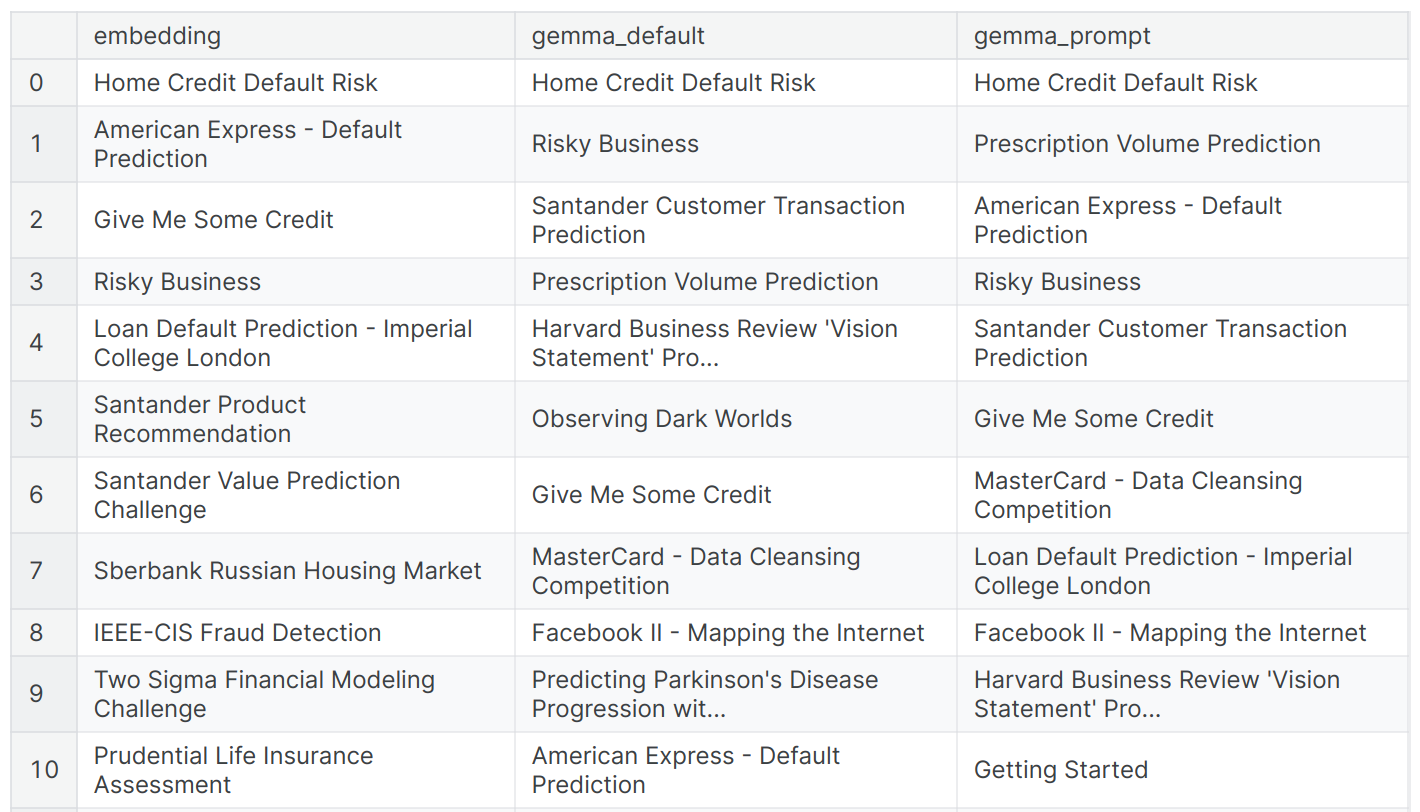

In the above, the gemma_default is with the default prompt of the used model (from the model page on HF), while the gemma_prompt is the customized prompt I tried with the model. The order changes a bit but in general the results are the same. Some of them actually look really off, such as the Facebook ones. I will look at those in the following. 

In [ ]:
#reverted_default_index = [int(top_k_indices[idx].cpu()) for idx in indices_gemma_default[:20]]
#df_compare_indices = pd.DataFrame({"embedding": top_k_indices[:20].cpu(), "gemma_default": reverted_default_index})
#df_compare_indices

### The common competitions in embeddings vs Gemma re-ranked

In [ ]:
#set(top_names_embedding[:20]) & set(top_names_gemma_default)

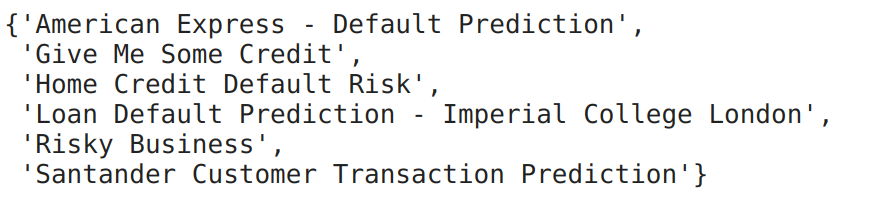

So these 6 competitions are in all cases in top 20 selected as most similar. They do actually look like very good candidates based on the naming at least. So perhaps they are not a total loss any of these models, and maybe even blending them could be useful. Would need more research.

### Unique Competitions Selected by Embeddings Search

In [ ]:
#set(top_names_embedding[:20]) - set(top_names_gemma_default) - set(top_names_gemma_prompt)

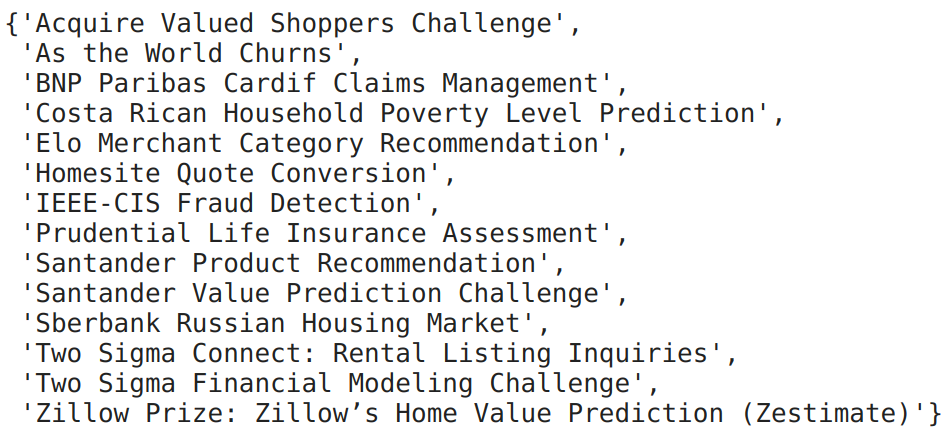

### Unique Gemma 2B Re-Ranker Selected Competitions

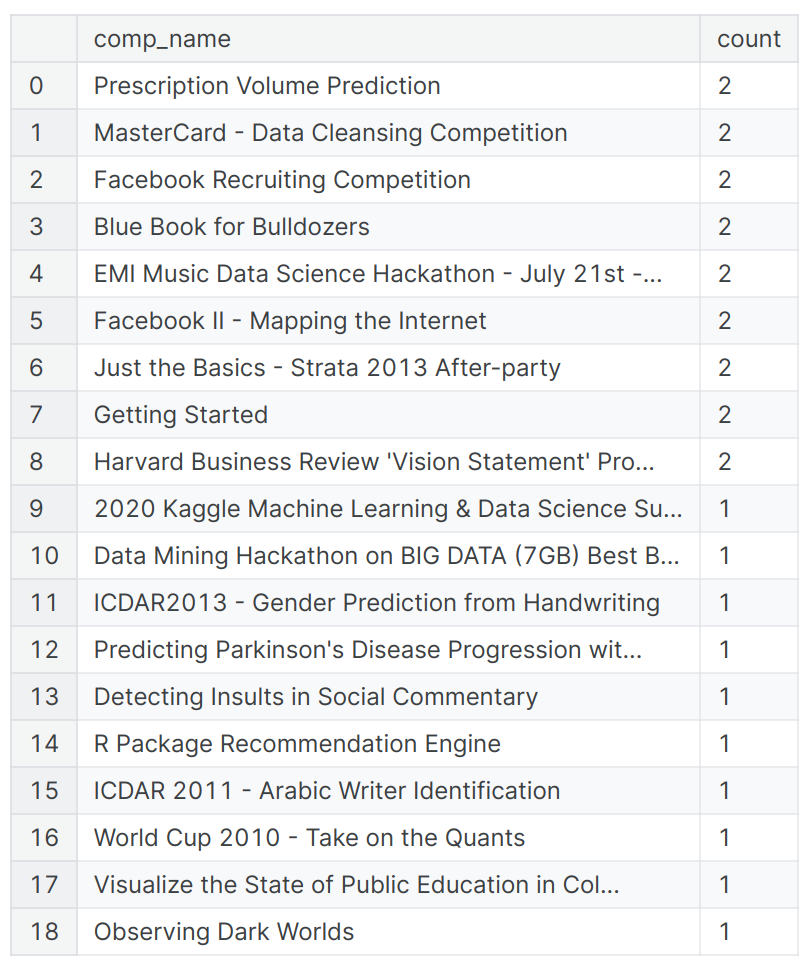

### Check on Strange Looking Competitions by Selected by Gemma 2B re-ranker

Some of the above results do not look like they make a lot of sense from the competition names. Lets look at descriptions for a few to see what it is.

In [ ]:
# print description for competition named "Facebook II - Mapping the Internet"
df_comp_meta[df_comp_meta["comp_name"] == "Facebook II - Mapping the Internet"]["desc"].values[0]

In [ ]:
df_comp_meta[df_comp_meta["comp_name"] == "Facebook II - Mapping the Internet"]

In [ ]:
df_comp_meta[df_comp_meta["comp_name"] == "EMI Music Data Science Hackathon - July 21st - 24 hours"]["desc"].values[0]

In [ ]:
df_comp_meta[df_comp_meta["comp_name"] == "EMI Music Data Science Hackathon - July 21st - 24 hours"]

The above descriptions do not really seem related to the description of the search competition. So I would say the Gemma 2B based re-ranker goes quite far off the track on this one (description comparison, not an exact question to answer). User error of course possible as well :).

Next off to summarization with Gemma..

# Summarize Writeups

This is based on my [previous Gemma notebook](https://www.kaggle.com/code/donkeys/gemma-for-kaggle-writeup-summaries), used here for summarizing large sets of writeups per competition into key points. The key points are then used to ask the model for more details on how the solutions in those key points were used in the competitions.

## Load Gemma 7B-it Model

In [ ]:
if on_kaggle:
    model_path = "/kaggle/input/gemma/transformers/7b-it/1"
else:
    model_path = "/mystuff/llm/gemma-7b-it"
#    model_path = "/mystuff/llm/gemma-7b"
    

g_tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)

#Gemma has 8096 context length:
#https://huggingface.co/google/gemma-7b-it/discussions/27

compute_dtype = getattr(torch, "float16")
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

g_model = AutoModelForCausalLM.from_pretrained(model_path, 
                                               device_map=DEVICE, 
                                               quantization_config=quantization_config)


# Load Writeups for Closest Competitions

The embeddings in part 1 above seemed to give best looking results for finding closest competitions. So I use the highest ranked of those as the base set here.

In [ ]:
len(top_names_embedding)

### Top 20 competitions based on embeddings search

Based on the above findings, I am going to use embeddings top 20 competitions

In [ ]:
top_names_embedding[:20]

### Filter out Competitions that don't have Multiple Writeups

Hard to summarize overall solutions if there are very few writeups.

In [ ]:
writeups = []
used_names = []
skipped_names_empty = []
skipped_names_few = []
top_scores = []

pbar_selected = tqdm(total=0, desc="Selected Writeups")
pbar_skipped_empty = tqdm(total=0, desc="Skipped (No Writeups)")
pbar_skipped_few = tqdm(total=0, desc="Skipped (Too Few Writeups)")

comps_to_find = 20

for idx, name in enumerate(top_names_embedding):
    comp_writeups = df_writeups[df_writeups["Title of Competition"] == name]
    #print(f"processing {name}, writeups: {comp_writeups.shape[0]}")
    if len(comp_writeups) == 0:
        #print(f"skipping {name} due to no writeups")
        skipped_names_empty.append(name)
        pbar_skipped_empty.update(1)
        continue
    if len(comp_writeups) < 5:
        #print(f"skipping {name} due to too few writeups")
        skipped_names_few.append(name)
        pbar_skipped_few.update(1)
        continue    
    used_names.append(name)
    writeups.append(comp_writeups)
    top_scores.append(top_k_values[0][idx])
    pbar_selected.update(1)
    if len(used_names) >= comps_to_find:
        break
    


The number of writeups that were skipped due to no or few writeups, and the number selected for further analysis:

In [ ]:
print(f"skipped names: {len(skipped_names_empty)}")
print(f"names with few: {len(skipped_names_few)}")
print(f"used names: {len(used_names)}")

In [ ]:
# find the indices of the top_names_used from the original top_names list
top_indices_used = [top_names_embedding.index(name) for name in used_names]
top_indices_used[:20]

In [ ]:
skipped_names_empty

In [ ]:
skipped_names_few

In [ ]:
# just to verify the selection is correct, 
# lets look at one that is dropped due to less than 5 writeups
df_writeups[df_writeups["Title of Competition"] == "Two Sigma Financial Modeling Challenge"].shape

This one had only 3, which is less than 5. So the filtering seems ok. Could probably downgrade the minimum requirement from 5 to 3, but lets keep it for this exercise.

The similarity scores for the top competitions:

In [ ]:
top_scores

In [ ]:
# the selected competitions
used_names

# Helper Functions 

In the following, I will use Gemma to chat about the top competition writeups based on those summaries. First a few helper functions to ease that, mostly from my [previous Gemma notebook](https://www.kaggle.com/code/donkeys/gemma-for-kaggle-writeup-summaries).

In [ ]:
def gemma_generate(prompt):
    input_ids = g_tokenizer(prompt, return_tensors="pt").to("cuda")
    input_token_count = len(input_ids["input_ids"][0])
    #print(input_token_count)
    outputs = g_model.generate(**input_ids, max_new_tokens=1000, do_sample=False)
    new_tokens = outputs[0][input_token_count:]
    output = g_tokenizer.decode(new_tokens)
    output_md = Markdown(output)
    return output, output_md

In [ ]:
def summarize_description(description):
    #print("summarizing description")
    prompt = f"Summarize the following kaggle competition description in a very concise way. "\
         f"Omit references to specific algorithms or known solutions, focus on overview of the contest topic and goals.\n\n" \
         f"description: {description}\n\n" \
         f"summary: "
    summary, summary_md = gemma_generate(prompt)
    return summary

# Split Writeups to Manageable Sets

Kaggle GPU runs out of memory when processing all these at once. So have to break them into smaller sets and re-combine the summarize by summarizing subsets and their results after.

The following split_list will split lists so about similar number of lists is in the last two slotes. Thus 21 values with a split of 5 would naively be [5,5,5,5,1] but with this they will be [5,5,5,3,3]. Helps summarizing more evenly.

In [ ]:
def split_list(data, max_sublist_size):
  """Splits a list into sublists with a maximum size and avoids uneven distribution.

  Args:
      data: The list to be split.
      max_sublist_size: The maximum size of each sublist.

  Returns:
      A list of sublists.
  """

  sublists = []
  current_sublist = []
  for idx, item in data.iterrows():
    if len(current_sublist) < max_sublist_size:
      current_sublist.append(item)
    else:
      sublists.append(current_sublist)
      current_sublist = [item]
  # Add the last sublist, even if it's shorter than max_sublist_size
  sublists.append(current_sublist)

  # Ensure the last sublists are more evenly distributed
  last_sublists = sublists[-2:]  # Get the last two sublists
  total_length = sum(len(sublist) for sublist in last_sublists)
  ideal_length = total_length // len(last_sublists)

  # Distribute elements until a balanced state is achieved
  while len(last_sublists[0]) > ideal_length and len(last_sublists) > 1:
      #print(len(last_sublists[0]))
      last_sublists[1].append(last_sublists[0].pop(0))

  # If there are still more elements in the second-to-last sublist, distribute to previous ones
  if len(last_sublists) > 1 and len(last_sublists[1]) > ideal_length:
    for i in range(len(sublists) - 2, 0, -1):
      if len(sublists[i]) < max_sublist_size:
        sublists[i].append(last_sublists[1].pop(0))
        break

  return sublists



In [ ]:
len(writeups)

The following splits the writeups to sets of max size N.

In [ ]:
# writeup dataframes will after this contain a dataframe per competition
# each dataframe holds a row per writeup in that competition
# this splits them so if N=10, a dataframe with 25 rows becomes 3 sub-dataframes with 10,10,5 writeups or so
writeup_dataframes = []
N = 10
for comp_writeups in writeups:
    writeups_sublists = split_list(comp_writeups, N)
    #print([len(sub) for sub in writeups_sublists])
    writeups_subframes = [pd.DataFrame(sub) for sub in writeups_sublists]
    #print([subframe.shape[0] for subframe in writeups_subframes])
    writeup_dataframes.append(writeups_subframes)
#writeup_dataframes[0]

# Summarize Writeups per Competition

This is based on my [previous Gemma notebook](https://www.kaggle.com/code/donkeys/gemma-for-kaggle-writeup-summaries).

In [ ]:
competitions = df_writeups["Title of Competition"].unique()
writeup_summaries = []
writeup_summaries_md = []
overall_summaries = []
processed_titles = set()
skipped_titles = set()
overall_summary_prompts = []
prompts = []
writeups = []
prompt_lengths = []
writeup_lengths = []
summary_lengths = []


In [ ]:
def summarize_competition_writeups(comps_to_summarize, df_writeups_here, max_comps=None):
    skip_count = 0
    for idx, competition in tqdm(enumerate(comps_to_summarize), total=len(comps_to_summarize)):
        df_comp = df_writeups_here[df_writeups_here["Title of Competition"] == competition]

        comp_name = df_comp["Title of Competition"].iloc[0]
        # have to skip overly long writeups. luckily not too many of those
        max_len = 8192 - 1001 #1000 here is requested count for max new tokens
        if on_kaggle:
            max_len = 4096 # Kaggle GPU seems unable to handle long sequence due to memory limit
        memory_error_msg = "skipped due to token limit (on Kaggle need shorter due to GPU memory limit)"
        #memory_skip = False

        # list_idx is to print position in saved lists, to be able to pick one later
        list_idx = len(overall_summaries)
        print(f"{list_idx}: competition {comp_name}, writeups {df_comp.shape[0]}")
        #here filter only the writeups for this competition
        intermediate = df_comp_meta[df_comp_meta["comp_name"] == comp_name]
        if intermediate.shape[0] == 0:
            # the two datasets I use here are not fully in sync, have to skip full mismatches
            print("competition metadata not found, skipping")
            skipped_titles.add(competition)
            skip_count += 1
            continue
        # on Kaggle it runs a bit slow at time, so had to implement some extra capping support
        if max_comps is not None and idx - skip_count >= max_comps:
            print("stopping due to maximum summaries reached")
            break

        comp_desc = df_comp_meta[df_comp_meta["comp_name"] == comp_name]["desc"].values[0]
        desc_summary = summarize_description(comp_desc)

        comp_writeup_summaries = []
        comp_writeup_summaries_md = []
        comp_prompts = []
        comp_writeups = []
        comp_prompt_lengths = []
        comp_writeup_lengths = []
        comp_summary_lengths = []
        prompts.append(comp_prompts)
        writeups.append(comp_writeups)
        writeup_summaries.append(comp_writeup_summaries)
        writeup_summaries_md.append(comp_writeup_summaries_md)
        prompt_lengths.append(comp_prompt_lengths)
        writeup_lengths.append(comp_writeup_lengths)
        summary_lengths.append(comp_summary_lengths)

        prompt_overall_summary = \
            f"The following gives a summary of a Kaggle competition description, " \
            f"and a set of one or more writeups on solutions used in that competition, separated by ======.\n\n" \
            f"Use these to summarize a set of guidelines for ideas on how to approach " \
            f"a given Kaggle data science competition. \n\n" \
            f"Competition description summary: {desc_summary}\n\n"

        # loop all writeups for each competition
        for i, row in tqdm(df_comp.iterrows(), total=df_comp.shape[0]):
            writeup_title = row["Title of Writeup"] 
            writeup = row["writeup_clean"]
            #print(i)

            prompt_writeup_and_desc = \
                 f"You are Gemma, a helpful assistant for Kaggle competitors to understand their datascience problems " \
                 f"and propose approaches to solve them. " \
                 f"Your points should have enough details to be useful for similar problem solving, " \
                 f"but not excessively focused on the specific approach in writeup. " \
                 f"More in the sense of overall application lessons for similar problems. " \
                 f"Here is a short summary of the competition now being analyzed:\n\n " \
                 f"description:\n {desc_summary}\n\n" \
                 f"Following will be a writeup of someone who participated in this competition. " \
                 f"List the key points of this from the datascience application viewpoint for similar problem solving.\n" \
                 f"Writeup:\n {writeup_title}:\n {writeup}\n\n" \
                 f"Answer: \n"

            input_ids = g_tokenizer(prompt_writeup_and_desc, return_tensors="pt")
            prompt_len = len(input_ids["input_ids"][0])

            comp_prompts.append(prompt_writeup_and_desc)
            comp_writeups.append(writeup)
            comp_prompt_lengths.append(prompt_len)
            input_ids = g_tokenizer(writeup_title+":\n"+writeup, return_tensors="pt")
            writeup_len = len(input_ids["input_ids"][0])
            comp_writeup_lengths.append(writeup_len)
            #print(f"prompt length: {prompt_len}, writeup length: {writeup_len}")

            if prompt_len > max_len:
                print(f"skipping writeup {writeup_title} for competition {competition} due to too high length {prompt_len}.")
                #continue
                summary, summary_md = memory_error_msg, memory_error_msg
                memory_skip = True
            else:
                summary, summary_md = gemma_generate(prompt_writeup_and_desc)

            # Store or process the 'summary' as needed
            #print(f"Competition: {comp_name}")
            #print(f"Writeup Title: {writeup_title}")
            #print(f"Summary: {summary}")
            #print("----------------------")
            comp_writeup_summaries.append(summary)
            comp_writeup_summaries_md.append(summary_md)
            input_ids = g_tokenizer(summary, return_tensors="pt")
            summary_len = len(input_ids["input_ids"][0])
            comp_summary_lengths.append(summary_len)

            input_ids = g_tokenizer(prompt_overall_summary, return_tensors="pt")
            prompt_overall_summary_len = len(input_ids["input_ids"][0])

            if prompt_overall_summary_len < max_len:
                prompt_overall_summary += f"\n\n======\n\n writeup summary:\n {summary}\n\n"
            else:
                print(f"skipping adding to overall prompt due to reaching max limit set: {prompt_overall_summary_len} > {max_len}")
            processed_titles.add(competition)

        prompt_overall_summary += \
            f"\n\n======\n\n Focus on the key points of the writeups and how they might have helped achieving better score in the competition." \
            f"Extract specifically used data analysis methods, and summarize how they are related across writeups.\n\n" \
            f"answer: "
        input_ids = g_tokenizer(prompt_overall_summary, return_tensors="pt")
        overall_prompt_len = len(input_ids["input_ids"][0])

        if overall_prompt_len > max_len:
            print(f"skipping overall summary for competition {competition} due to too high length {overall_prompt_len}.")
            overall_summary, overall_summary_md = memory_error_msg, memory_error_msg
        else:
            overall_summary, overall_summary_md = gemma_generate(prompt_overall_summary)

        input_ids = g_tokenizer(overall_summary, return_tensors="pt")
        overall_summary_len = len(input_ids["input_ids"][0])
        
        #print(overall_summary)
        print(f"     prompt lengths={comp_prompt_lengths}")
        print(f"    writeup lengths={comp_writeup_lengths}")
        print(f"    summary lengths={comp_summary_lengths}")
        print(f"    total writeups length:{sum(comp_writeup_lengths)}, overall prompt length: {overall_prompt_len}, overall summary length: {overall_summary_len}")
        overall_summaries.append(overall_summary_md)
        overall_summary_prompts.append(prompt_overall_summary)
    print(f"total of {len(prompts)} competitions processed")


## List of Competitions Selected to Summarize

Just as a reminder of how did the selection earlier end up.

In [ ]:
len(used_names)

In [ ]:
len(writeup_dataframes)

In [ ]:
#display(writeup_dataframes[0])

## Summarize Writeups for Selected Competitions in Sets of Writeups

The subsets are used to manage GPU memory better. The subsets per competition will be summarized together to get a single summary per competition after.

In [ ]:
# just using the top 5 competitions and their writeups here to keep the runtime reasonable.
# its a tradeoff in the end to investigate how to select the best number in any case..
#for x in range(len(used_names[:5])):
for x in range(len(used_names)):
    name = used_names[x]
    # writeup_dataframes holds the writeups for the competition name at same index
    for df_subframe in writeup_dataframes[x]:
        summarize_competition_writeups([name], df_subframe)



## Recombine Competition Writeup Sub-Summaries

Now we have a list of summaries per competition, each summarizing some 2-5 writeups together. For example, [summary1, summary2, summary3] for a single competition. This summarizes these competition writeup summaries into a single final writeup summary per competition. 

So in this case those 3 summaries would become one [final_summary_for_competition_1]. This is done for each competition until there is just one final writeup summary per competition. Gemma seems to do quite well in this type of hierarchical summarization.


In [ ]:
def recombine_summaries(summaries, sublist_lengths):
    result = []
    start_index = 0
    for length in sublist_lengths:
        end_index = start_index + length
        result.append(summaries[start_index:end_index])
        start_index = end_index

    return result 

# Example usage
summaries = ["summary1_1", "summary1_2", "summary2_1", "summary2_2", "summary3_1"]
sublist_lengths = [2, 2, 1]

recombine_summaries(summaries, sublist_lengths)
# Output: [['summary1_1', 'summary1_2'], ['summary2_1', 'summary2_2'], ['summary3_1']]


In [ ]:
sublist_lengths = [len(sub) for sub in writeup_dataframes]
sublist_lengths


In [ ]:
combined = recombine_summaries(overall_summaries, sublist_lengths)


In [ ]:
#checks how many sub-summaries each competition has
[len(sub) for sub in combined]


# Check on a Competition Sub-Summaries

Lets see what the competition writeup sub-set summaries look like:

In [ ]:
combined[0][0]

In [ ]:
combined[0][1]

In [ ]:
combined[0][2]

In [ ]:
combined[0][2].data

# Summarize Competition Sub-Summaries into a single one

Here the overall summarization happens. So [summary1, summary2, summary3] per competition now becomes [final_summary_for_competition_1] (for competition1), as noted above. 

In [ ]:
def summarize_subsummaries(sublist):
    writeup_summaries = [summary.data for summary in sublist]
    points = "\n\n".join(writeup_summaries)
    prompt = f"""collect the key points listed in these writeup summaries into one list of key points.
    include the descriptions given for these key points.
    do not add any new points or summarize these in any way beyond collection the points and their descriptions:
    
    {points}
    """
    summary, summary_md = gemma_generate(prompt)
    return summary, summary_md

In [ ]:
len(combined)

In [ ]:
summary, summary_md = summarize_subsummaries(combined[0])

# Look at a Final Summary, Pick a Question

Just a check on the overall summary of the selected competition above. The key points from this will be used as a question to Gemma to start a chat about what solutions are used in those competitions.

In [ ]:
summary_md

# Setting up RAG Pipeline to Answer the Questions

First the base embedding model used for the chunks.

In [ ]:
if on_kaggle:
    llm = "/kaggle/input/bge-base-en-v1-5/bge-base-en-v1.5"
else:
    llm = "/mystuff/llm/bge-base-en-v1.5"
bge_tokenizer = AutoTokenizer.from_pretrained(llm, local_files_only=True)

#try to get chunks of about 256 tokens for the writeups
text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    bge_tokenizer, chunk_size=256, chunk_overlap=32, separators=["\n\n", "\n", ". "]
)


In [ ]:
embed_model = SentenceTransformer(llm)

## FAISS vector store for similarity search over chunks

In [ ]:
test_embeddings = embed_model.encode(["text for test"], normalize_embeddings=True)
d = test_embeddings.shape[1]
faiss_index = faiss.index_factory(d, "Flat")

In [ ]:
d

## Flatten Writeups for RAG Chunking

In [ ]:
flat_list_of_dfs = [item for sublist in writeup_dataframes for item in sublist]

result_df = pd.concat(flat_list_of_dfs, ignore_index=True) 


In [ ]:
len(writeup_dataframes)

In [ ]:
result_df

# Iterate, Chunk, and Index all Writeups

The collected writeups are only for the most similar competitions selected at the beginnign of this notebook. So I will use all these writeups as the search documents here. 

In [ ]:
all_chunks = []
# chunk metas will contain the dataframe row (writeup id)
# and the chunk id within that writeup
chunk_metas = []

for i, row in result_df.iterrows():
    text = row["writeup_clean"]
    # the text seems to sometimes have some strange unicode spaces:
    # https://stackoverflow.com/questions/10993612/how-to-remove-xa0-from-string-in-python
    text = text.replace(u'\xa0', u' ')
    chunks = text_splitter.split_text(text)
    embeddings = embed_model.encode(chunks, normalize_embeddings=True)#, show_progress_bar=True)
    faiss_index.add(embeddings)
#    token_count = len(tokenizer(chunk)["input_ids"])
#    if token_count > 500:
#        print(f"too long chunk for model: {i}:{chunk_idx} = {token_count}")
    chunk_metas.extend((i, chunk_idx) for chunk_idx in range(0, len(chunks)))
    all_chunks.extend(chunks)



In [ ]:
len(all_chunks)

In [ ]:
result_df.shape

In [ ]:
len(chunk_metas)


In [ ]:
# simiple sanity check if there are overly long chunks for some reason
texts_filtered = []
for text in all_chunks:
    token_count = len(g_tokenizer(text)["input_ids"])
    if token_count < 500:
        continue
    texts_filtered.append(text)

# Chunk Similarity Search and Re-ranking

Re-ranking with a specific model takes a bit longer but generally is thought to give better ranking. This time I will trial question-based re-ranking using a more traditional Cross-Encoder re-ranker and again the Gemma 2B based LLM re-ranker. I expect the LLM re-ranker should do better here vs the description search, as it is intended for question-based re-ranking.

In [ ]:
import time

def mbxai_rerank_question_docs(query, documents, k=20):
    if on_kaggle:
        llm = "/kaggle/input/mxbai-rerank-large-v1/mxbai-rerank-large-v1"
    else:
        llm = "/mystuff/llm/mxbai-rerank-large-v1"
    model = CrossEncoder(llm)
    start_time = time.time()
    results = model.rank(query, documents, return_documents=True, top_k=k)
    end_time = time.time()
    print(f"time to rerank: {end_time-start_time} seconds")
    indices = [result['corpus_id'] for result in results]
    scores = [result['score'] for result in results]
    texts = [result['text'] for result in results]
    del model
    return scores, texts, indices


In [ ]:
def find_rag_chunks(query, k=5):
    q_embeddings = embed_model.encode([query], normalize_embeddings=True, show_progress_bar=True)
    q_array = np.array(q_embeddings)
    faiss_scores, faiss_indices = faiss_index.search(q_array, k)

    selected_chunks = []
    selected_comps = []
    selected_chunk_idx = []
    for chunk_idx in faiss_indices[0]:
        chunk = all_chunks[chunk_idx]
        selected_chunks.append(chunk)
        chunk_meta = chunk_metas[chunk_idx]
        competition_idx = chunk_meta[0]
        chunk_idx = chunk_meta[1]
        selected_comps.append(competition_idx)
        selected_chunk_idx.append(chunk_idx)
        comp_title = result_df.iloc[competition_idx]["Title of Competition"]
        writeup_title = result_df.iloc[competition_idx]["Title of Writeup"]
    # selected chunks is the actual content. selected comps=just the index of the competition
    return selected_chunks, selected_comps, selected_chunk_idx

def rerank_rag_chunks(query, input_chunks, k=5, use_gemma=True):
    if use_gemma:
        scores_rag_chunks, sorted_rag_chunks, indices_rag_chunks = gemma_rerank_question_docs(query, input_chunks)
    else:
        scores_rag_chunks, sorted_rag_chunks, indices_rag_chunks = mbxai_rerank_question_docs(query, input_chunks)
    return scores_rag_chunks[:k], sorted_rag_chunks[:k], indices_rag_chunks[:k]

In [ ]:
# sometimes Gemma specific cleaning is needed
def remove_eos(text):
    if text.endswith("<eos>"):
        return text[:-5]
    else:
        return text

## Use Re-Ranked Chunks as Context, Answer Questions with Gemma

In [ ]:
def build_rag_input(input_chunks, query):
    rag_input = "\n\n".join(input_chunks)
    prompt1 = f"""given the following context:\n{rag_input}\n
answer the following question: {query}\n\n
"""
    chat = [
        { "role": "user", "content": prompt1 },
    ]
    prompt = g_tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
    return prompt, chat

In [ ]:
def rag_bootstrap(query, use_gemma=True):
    # chunks were made at about 256 tokens max cap, so 10 chunks should be about 2000 tokens
    # this should be a good starting point for the model and also likely fits even in kaggle GPU RAM
    # thus I start with 50 chunks in retrieval and 10 in reranking
    selected_chunks, selected_comps, selected_chunk_idx = find_rag_chunks(query, k=50)
    _, sorted_rag_chunks, _ = rerank_rag_chunks(query, selected_chunks, k=10, use_gemma=use_gemma)
    prompt, chat = build_rag_input(sorted_rag_chunks, query)
    answer = gemma_generate(prompt)
    answer = remove_eos(answer[0])
    return answer, chat
    

In [ ]:
def rag_on(chat_so_far, answer, query):
    chat_so_far.append({"role": "model", "content": answer})
    chat_so_far.append({"role": "user", "content": query})
    prompt = g_tokenizer.apply_chat_template(chat_so_far, tokenize=False, add_generation_prompt=True)
    answer = gemma_generate(prompt)
    answer = remove_eos(answer[0])
    return answer, chat_so_far

# Some Example Questions and Answers 

Now for an example question and its answer. First, a reminder of the summary of key points from earlier:

In [ ]:
summary_md

I will first ask about feature engineering first from these key points. It is quite a common topic in competitions, so lets see: 

In [ ]:
q = "what kind of feature engineering is used in these solutions?"

## Gemma 7B-it answer with Gemma 2B re-ranked context


In [ ]:
%%time
answer, g_chat = rag_bootstrap(q)
Markdown(answer)

In [ ]:
%%time
answer, g_chat = rag_on(g_chat, answer, "how do they use feature interactions?")
Markdown(answer)

In [ ]:
%%time
answer, g_chat = rag_on(g_chat, answer, "thats nice thanks. what kind of feature interactions are used in datascience in general besides these writeups?")
Markdown(answer)

In [ ]:
%%time
q2 = "can you give me examples of how feature interactions are used in these solutions?"
answer, g_chat2 = rag_bootstrap(q2)
Markdown(answer)

In [ ]:
#Markdown(chat[0]["content"])

In [ ]:
#https://huggingface.co/BAAI/bge-reranker-base
#https://huggingface.co/BAAI/bge-m3
#https://huggingface.co/BAAI/bge-reranker-v2-gemma
#https://huggingface.co/mixedbread-ai/mxbai-rerank-large-v1

# Cross-Encoder (MXBAI) Reranker

Now for the Cross-Encoder based re-ranking context. This should at least be much faster than the LLM re-ranker, and in my experience these do quite well. Let's see.


In [ ]:
%%time
answer, mx_chat = rag_bootstrap(q, False)
Markdown(answer)

In [ ]:
%%time
answer, mx_chat = rag_on(mx_chat, answer, "how do they use feature interactions?")
Markdown(answer)

In [ ]:
%%time
q2 = "can you give me examples of how feature interactions are used in these solutions?"
answer, g_chat2 = rag_bootstrap(q2, False)
Markdown(answer)

# Conclusions for These Experiments

Well, this has been an interesting experiment. A few conclusions on this notebook so far:

- **Summarization**: 
  - As noted in my previous notebook, Gemma does quite good in summarizing key points, as long as the prompts are tuned to the application. 
  - Gemma also did well in summarizing subset summaries into a final, overall summary.
  - For RAG style Q&A, the key points of summaries seem to provide good points to get into more details via chatting with Gemma.
- **RAG Q&A**: 
  - Gemma seems to stick quite strictly to its given context. Which is good I guess to prevent too much hallucination, but something to keep in mind if want broader context.
  - This seems to make it a bit more sensitive to context building. Something to keep in mind.

**Gemma 2B re-ranker Observations**:

- **Speed**: 
  - As expected, the LLM re-ranker is significantly slower than the more traditional Cross-Encoders re-ranker. 
  - If that is acceptable tradeoff to manage, it seems useful to investigate as an option for question-based re-ranking.
- **Performance**: 
  - The Gemma 2B LLM re-ranker results for competition description comparison did not seem very impressive, possible due to being intended for question-based re-ranking.
  - For question based answer re-ranking, it seems to have more potential, and including it as an option to consider again something to keep in mind if the speed tradeoff is not too big.

(to be continued another day..)